# Band Ratios: Literature Search

Here we will explore the prevalence of band-ratio measures in the literature.

To do so, we will use [LISC](https://github.com/lisc-tools/lisc), a Python module for collecting and analyzing scientific literature. More information on LISC can be found in the [docs](https://lisc-tools.github.io/lisc/).

To explore the prevalence and use cases of band ratio measures, we will collect information from the Pubmed database on the number of papers that include search terms mentioning band ratio measures, as well as the number of papers that mention these terms of interest in co-occurrence with specified association terms.

Note that collecting literature data in this way is likely an under-estimate of the use of band-ratio measures, as this approach employed here only searches for search terms occurring in abstracts.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context('talk')

In [2]:
# Import LISC code
from lisc import Counts
from lisc.utils import save_object, load_object
from lisc.plts.counts import plot_matrix
from lisc.plts.utils import get_cmap

In [3]:
# Import custom project code
import sys
sys.path.append('../bratios')

from paths import DATA_PATHS as dp
from paths import FIGS_PATHS as fp

In [4]:
# Initialize counts object
counts = Counts()

In [5]:
# Settings for literature collection
db = 'pubmed'

In [6]:
# Notebook settings
SAVE_FIG = False    # Whether to save out figures
SAVE_DATA = False   # Whether to save out collected literature data
RUN_COL = False     # Whether to re-run the data collection. If False, tries to load previously saved data

### Define Ratio Terms

First, we will define a list of search terms to search for band ratio measures of interest. 

The following ratios were not included, as they do not return enough papers in our restricted title / abstract search:
- delta gamma ratio
- alpha gamma ratio

In [7]:
# Set terms list
br_terms = [['delta theta ratio', 'delta/theta ratio', 'theta delta ratio'],
            ['delta alpha ratio', 'delta/alpha', 'alpha delta ratio'],
            ['delta beta ratio', 'beta delta ratio'],
            ['theta alpha ratio', 'theta/alpha ratio', 'alpha theta ratio'],
            ['theta beta ratio', 'theta/beta ratio', 'beta theta ratio'],
            ['theta gamma ratio', 'theta/gamma ratio'],
            ['alpha beta ratio', 'beta alpha ratio', 'alpha/beta ratio']
           ]

# Set exclusion terms
#   DAR & ABR has specific inclusions, to restrict to relevant papers
#   This is because there is a lot of synonymous use of the term 'alpha beta ratio' and 'delta alpha ratio'
br_inclusions = [[], ['EEG', 'electroencephalography'], [], [], [], [], ['EEG', 'electroencephalography']]

# Check that the search terms and exclusions line up
assert len(br_terms) == len(br_inclusions)

### Define Association Terms

We will also define a set of association terms, so that we can explore what ratio measures are used for in the literature.

In [8]:
# Set list of association terms of interest
assoc_terms = [
    ['ADHD', 'attention deficit hyperactivity disorder'],
    ['executive function', 'attentional control', 'cognitive control'],
    ['neurofeedback'],
    ['sleep', 'polysomnography'], 
    ['stroke', 'ischemia', 'brain injury', 'coma'], 
    ['learning', 'memory', 'cognitive impairment', 'dementia']
]

In [9]:
# Add band-ratio terms to object
counts.add_terms(br_terms)
counts.add_terms(br_inclusions, term_type='inclusions')

In [10]:
# Add association terms to object
counts.add_terms(assoc_terms, dim='B')

In [11]:
# Check terms
counts.terms['A'].check_terms()

List of terms used: 

delta theta ratio  : delta theta ratio, delta/theta ratio, theta delta ratio
delta alpha ratio  : delta alpha ratio, delta/alpha, alpha delta ratio
delta beta ratio   : delta beta ratio, beta delta ratio
theta alpha ratio  : theta alpha ratio, theta/alpha ratio, alpha theta ratio
theta beta ratio   : theta beta ratio, theta/beta ratio, beta theta ratio
theta gamma ratio  : theta gamma ratio, theta/gamma ratio
alpha beta ratio   : alpha beta ratio, beta alpha ratio, alpha/beta ratio


In [12]:
# Check terms
counts.terms['B'].check_terms()

List of terms used: 

ADHD                : ADHD, attention deficit hyperactivity disorder
executive function  : executive function, attentional control, cognitive control
neurofeedback       : neurofeedback
sleep               : sleep, polysomnography
stroke              : stroke, ischemia, brain injury, coma
learning            : learning, memory, cognitive impairment, dementia


### Collect literature data

Runs the scrape for counts of each term, and the co-occurrence of band ratio and association terms. 

In [13]:
# Run the data collection
if RUN_COL:
    counts.run_collection(db=db)
else:
    counts = load_object('brs_counts.p', directory=dp.literature)

### Check and Process Collected Data

Check how many papers were found, and normalize data.

In [14]:
# Check how many papers were found for each ratio search term
counts.check_counts()

The number of documents found for each search term is:
  'delta theta ratio'   -    13
  'delta alpha ratio'   -    50
  'delta beta ratio'    -    15
  'theta alpha ratio'   -    55
  'theta beta ratio'    -   105
  'theta gamma ratio'   -     8
  'alpha beta ratio'    -    20


In [15]:
# Check the total number of papers across all ratio terms
n_total = sum(counts.terms['A'].counts)
print('Total number of band ratio papers is: \t', n_total)

Total number of band ratio papers is: 	 266


In [16]:
# Since different ratios have different numbers of results, we will normalize the association results
counts.compute_score('normalize', dim='A')

In [17]:
# Set adapted versions of the labels to use as plot labels
ratio_labels = ['delta / theta', 'delta / alpha ', 'delta / beta ', 'theta / alpha',
                'theta / beta', 'theta / gamma', 'alpha / beta']
assoc_labels = ['ADHD', 'attention', 'neurofeedback', 'sleep', 'stroke', 'learning']

### Create Visualizations of Collected Data

Create plots of associations and counts.

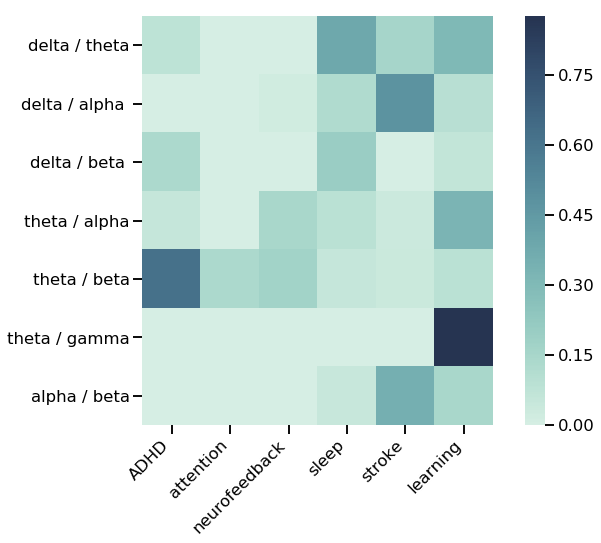

In [18]:
# Plot the associations of band ratio measures in the literature
fig, ax = plt.subplots(figsize=(10, 8))
plot_matrix(counts.score, assoc_labels, ratio_labels, cmap='blue', square=True, ax=ax)
plt.xticks(rotation=45, horizontalalignment='right');

if SAVE_FIG: plt.savefig(fp.make_file_path(fp.literature, 'LISC-Associations', 'pdf'))

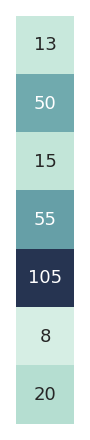

In [19]:
# Plot the number of papers found per ratio measure
dat = np.expand_dims(counts.terms['A'].counts, 1)

fig, ax = plt.subplots(figsize=(2.5, 7.5))
sns.heatmap(dat,
            cmap=get_cmap('blue'),
            xticklabels=[],
            yticklabels=[],
            annot=True, annot_kws={"size": 18}, cbar=False, fmt='d', square=True);

if SAVE_FIG: plt.savefig(fp.make_file_path(fp.literature, 'LISC-Counts', 'pdf'))

In [20]:
# Save out the collected data
if SAVE_DATA:
    save_object(counts, 'brs_counts', directory=dp.literature)